<a href="https://colab.research.google.com/github/DanielDanger/mlBachelor/blob/daniel/ML_Bachelor_Projektarbeit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 


# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [2]:
import pandas as pd
link = 'https://drive.google.com/file/d/1u1gYmv2sDvoo_Lh6J1QyDlb_ldtiH2G5/view?usp=sharing'

# to get the id part of the file 
id = link.split("/")[-2] 
  
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('train.csv')   
  
df_train = pd.read_csv('train.csv') 

link = 'https://drive.google.com/file/d/1e-di8EI_pVCowDaZxb_SQlovzfKkB9_Z/view?usp=sharing'

# to get the id part of the file 
id = link.split("/")[-2] 
  
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('test.csv')   
  
df_test = pd.read_csv('test.csv') 


# Business Understanding 

# Data Understanding

Hier sollte ggf. mal eine Darstellung erfolgen, welche Werte nicht vorhanden sind 

# Data Preparation

Als erstes muss der Basket in eine Liste transformiert werden -> dazu wird eine Funktion geschrieben. 

In [3]:
import ast
def calculate_basket_size(dfi): 
  dfi["basket_size"] = dfi.basket.apply(lambda x: len(ast.literal_eval(x)))
  return dfi

Funktion, welche die Fehlenden Werte im Dataframe füllt 

In [4]:
import statistics
def fill_na(df):
  df['totalAmount'].fillna((df['totalAmount'].mean()), inplace=True)
  df["customerType"].fillna(statistics.mode(df["customerType"]), inplace= True)
  return df

Funktion, welche die Spalte *basket* in eine Liste transformiert und dem Dataframe anhängt

In [5]:
import json
def transform_basket_tolist(dfp):
  print(dfp)
  basket_list = dfp["basket"].values.tolist()
  new_basket_list = []
  for x in basket_list:
    basket = json.loads(x)
    new_basket_list.append(basket)
  dfp["basket_new"] = new_basket_list
  return dfp

In [6]:
def count_occurences(df):
  df1 = df['basket_new'].explode()
  df = df.join(pd.crosstab(df1.index, df1).add_prefix('Cat_')) # TransactionId wird aufgrund fehlender Relevanz nicht weiter betrachtet
  print(df)
  return df

  #[['customerType','totalAmount','returnLabel']] DeDa rausgeworfen 

In [7]:
#Überprüfung, ob eine Kategorie im Basket vorhanden ist, One hot encoding der Kategorien 
def cat_in_basket(dfi):
  i=0
  while i<=5:
    cat="Cat_"+str(i)
    dfi[cat]=dfi[cat].map(lambda x: 1 if x > 0 else 0)
    i=i+1
  return dfi

In [8]:
# CustomerType in 0 und 1 umbauen 
from pandas.api.types import is_string_dtype
def map_customer(df): 
  if (is_string_dtype(df.customerType)):
    df.customerType=df.customerType.map({'existing':1,'new':0})

In [9]:
# Funktion die Zählt, wie oft ist eine Kategorie in einem Warenkorb vorhanden
def count_categories(dfi1): 
  df1 = dfi1['basket_new'].explode()
  dfi1=dfi1[['customerType','totalAmount','returnLabel','basket_size']].join(pd.crosstab(df1.index, df1, colnames=['b']).add_prefix('Cat_')) # Das Teil muss ich nochmal checken 
  dfi1=dfi1[['customerType','Cat_0','Cat_1','Cat_2','Cat_3','Cat_4','Cat_5','totalAmount','returnLabel','basket_size']]
  return dfi1

In [10]:
#Diese Funktion berechnet das Verhätnis mit welcher Wahrscheinlichkeit ein Buch zurückgesendet wird. 
def cal_return_prob(dfi):
    # Kennzahlen für den Bereich der Rücksendungen ermitteln 
    books_returned = dfi[dfi.returnLabel==1]
    books_returned = books_returned.sum(axis = 0, skipna = True)
    books_returned_array = books_returned[["Cat_0","Cat_1","Cat_2","Cat_3","Cat_4","Cat_5"]].to_numpy()  
    #Summe aller Spalten -> dann nur die Kategorien rausfiltern 
    all_books = dfi.sum(axis = 0, skipna = True)
    all_books_array = all_books[["Cat_0","Cat_1","Cat_2","Cat_3","Cat_4","Cat_5"]].to_numpy()

    #Berechne das Rücksendeverhältnis der einzelnen Kategorien 
    verhältnis = books_returned_array / all_books_array

    return verhältnis

In [11]:
#Ermittelt für einen Warenkorb die Rücksendewahrscheinlichkeit 
def return_prob(dfi):
  
  verhältnis = cal_return_prob(dfi)
  df_return = dfi
  df_return["basket_size"] = df_return.Cat_0+ df_return.Cat_1+df_return.Cat_2+df_return.Cat_3+df_return.Cat_4+df_return.Cat_5
  df_return["return_prob"] = (df_return.Cat_0*verhältnis[0]+df_return.Cat_1*verhältnis[1]+df_return.Cat_2*verhältnis[2]+df_return.Cat_3*verhältnis[3]+df_return.Cat_4*verhältnis[4]+df_return.Cat_5*verhältnis[5])/(
  df_return.basket_size)
  return df_return

In [12]:
#Ermittelt den häufigsten Wert eines Warenkorbs 
from collections import Counter
def top_category(df):
  df["top_cat"] = df.basket_new.apply(lambda x: Counter(x).most_common(1)[0][0])
  return df

In [13]:
# Funktion zur Datenvorbereitung hier wird wirklich nur ein OneHot encoding durchgeführt. 


def prepare_data(dfi): 
    #dfi.drop(columns='transactionId',inplace=True)
    map_customer(dfi)
    transform0 = calculate_basket_size(dfi)
    transform1 = transform_basket_tolist(transform0)
    transform2 = count_occurences(transform1)
     
#print(prepare_data(df_test))



In [14]:
from sklearn.preprocessing import StandardScaler
 
#Funktion, um Scaler mit den Parametern zu erstellen
def get_scaler(dfi):
  scaler = StandardScaler()
  df_for_scaling = dfi.drop(columns=['returnLabel'])
  scaler = scaler.fit(df_for_scaling)
  return scaler
 
#Funktion, um Daten zu skalieren
def scale_data(scaler,dfi):
  df_for_scaling = dfi.drop(columns=['returnLabel'])
  scaled_data = scaler.transform(df_for_scaling)
  return scaled_data

In [15]:
# Funktion zur Datenvorbereitung hier wird solch eine Transformation durchgeführt, die für die jeweiligen Gruppen/Warenkörbe ermittelt, mit welchen Wahrscheinlichkeiten etwas zurück kommt.  



def prepare_train(dfi): 
    #dfi.drop(columns='transactionId',inplace=True)
    y_train = dfi.returnLabel
    dfi = fill_na(dfi)
    map_customer(dfi)
    dfi = calculate_basket_size(dfi)
    dfi = transform_basket_tolist(dfi)
    dfi =  top_category(dfi)
    # hier ist der Unterschied zur anderen prep. Funktion 
    dfi = count_categories(dfi) # Wichtig ist, dass diese Funktion vor der nächsten steht 
    #transform3 = cal_return_prob(transform2)
    dfi = return_prob(dfi) 
    scaler = get_scaler(dfi)
    x_train = scale_data(scaler,dfi)
    
    return x_train,y_train, scaler  

def prepare_test(dfi,scaler): 
    dfi.dropna(axis=0, inplace=True)
    df_test_Y = dfi.returnLabel
    dfi = dfi.drop(columns=['transactionId'])
    map_customer(dfi)
    dfi = calculate_basket_size(dfi)
    dfi = transform_basket_tolist(dfi)
    dfi = top_category(dfi)
    dfi = count_categories(dfi)
    dfi = return_prob(dfi)
    df_test_X = scale_data(scaler,dfi)
    return df_test_X,df_test_Y

In [16]:
#x,scaler = prepare_train(df_test1)
#df = pd.DataFrame(x, columns = ["customerType",	"Cat_0",	"Cat_1",	"Cat_2",	"Cat_3",	"Cat_4",	"Cat_5",	"totalAmount"	,"basket_size",	"return_prob"])

df_test

,transactionId,basket,customerType,totalAmount,returnLabel
0,9605027322,"[4, 0, 3, 4, 1, 4, 3, 4]",new,80.0,1
1,8315649406,[4],existing,26.0,0
2,5151646801,"[1, 3, 5]",existing,147.0,0
3,8101967972,[3],existing,37.0,1
4,2887044104,"[0, 0, 2, 5, 2]",existing,375.0,0
...,...,...,...,...,...
5995,8254392242,"[3, 4, 4]",existing,192.0,1
5996,5691788621,"[4, 4, 3, 4, 1, 4]",new,360.0,1
5997,1449561534,"[3, 4, 4, 4]",existing,252.0,0
5998,9039960511,"[5, 1]",existing,50.0,0


In [17]:
X_train,y_train,scaler = prepare_train(df_train)
X_test,y_test = prepare_test(df_test,scaler)



       transactionId  ... basket_size
0         7934161612  ...           1
1         5308629088  ...           4
2         1951363325  ...           4
3         6713597713  ...           1
4         8352683669  ...           4
...              ...  ...         ...
24995     8178087221  ...           9
24996     8955146476  ...          12
24997     7770630838  ...           6
24998     3758775159  ...           2
24999     7697226342  ...           5

[25000 rows x 6 columns]
                        basket  customerType  ...  returnLabel  basket_size
0     [4, 0, 3, 4, 1, 4, 3, 4]             0  ...            1            8
1                          [4]             1  ...            0            1
2                    [1, 3, 5]             1  ...            0            3
3                          [3]             1  ...            1            1
4              [0, 0, 2, 5, 2]             1  ...            0            5
...                        ...           ...  ...          ...

Diese Funktion macht eine Darstellung, wie oft welche Buchkategorien in den Rücksenden enthalten waren.

Das Teil muss isoliert betrachtet werden 

       transactionId  ... top_cat
0         7934161612  ...       3
1         5308629088  ...       3
2         1951363325  ...       3
3         6713597713  ...       2
4         8352683669  ...       4
...              ...  ...     ...
24995     8178087221  ...       4
24996     8955146476  ...       5
24997     7770630838  ...       4
24998     3758775159  ...       5
24999     7697226342  ...       4

[25000 rows x 8 columns]
       transactionId                                basket  ...  Cat_4  Cat_5
0         7934161612                                   [3]  ...      0      0
1         5308629088                          [5, 3, 0, 3]  ...      0      1
2         1951363325                          [3, 3, 1, 4]  ...      1      0
3         6713597713                                   [2]  ...      0      0
4         8352683669                          [4, 4, 4, 4]  ...      4      0
...              ...                                   ...  ...    ...    ...
24995     8178087221

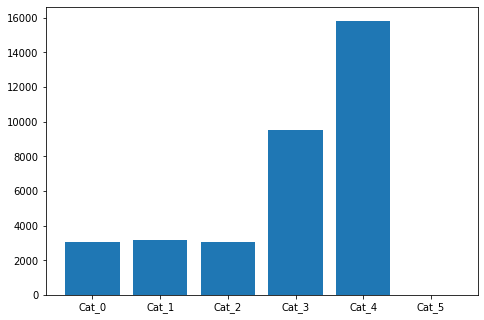

In [18]:
df_train_new = count_occurences(df=transform_basket_tolist(df_train))

import matplotlib.pyplot as plt
import numpy as np



# Hole alle Rücksendungen aus dem Daframe
df_train_return = df_train_new[df_train['returnLabel']==1] 

cat_array = df_train_return.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new","top_cat","customerType","basket_size"]) # Wirf alles bis auf die Kategorien raus 

# Wie viele Objekte sind im Dataframe vorhanden? 
df_calc = cat_array.sum(axis = 0, skipna = True) 
# Transformiere alle relevaten Spalten in ein NumpyArray damit wir es im Barchart darstellen können 
#cat_array = df_calc.drop(columns=["totalAmount","returnLabel"]).to_numpy()

print(df_calc)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cats = ['Cat_0', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5'] #Label für die X Achse 


ax.bar(cats,list(df_calc))
plt.show()

       transactionId  ... top_cat
0         7934161612  ...       3
1         5308629088  ...       3
2         1951363325  ...       3
3         6713597713  ...       2
4         8352683669  ...       4
...              ...  ...     ...
24995     8178087221  ...       4
24996     8955146476  ...       5
24997     7770630838  ...       4
24998     3758775159  ...       5
24999     7697226342  ...       4

[25000 rows x 8 columns]
       transactionId                                basket  ...  Cat_4  Cat_5
0         7934161612                                   [3]  ...      0      0
1         5308629088                          [5, 3, 0, 3]  ...      0      1
2         1951363325                          [3, 3, 1, 4]  ...      1      0
3         6713597713                                   [2]  ...      0      0
4         8352683669                          [4, 4, 4, 4]  ...      4      0
...              ...                                   ...  ...    ...    ...
24995     8178087221

ValueError: ignored

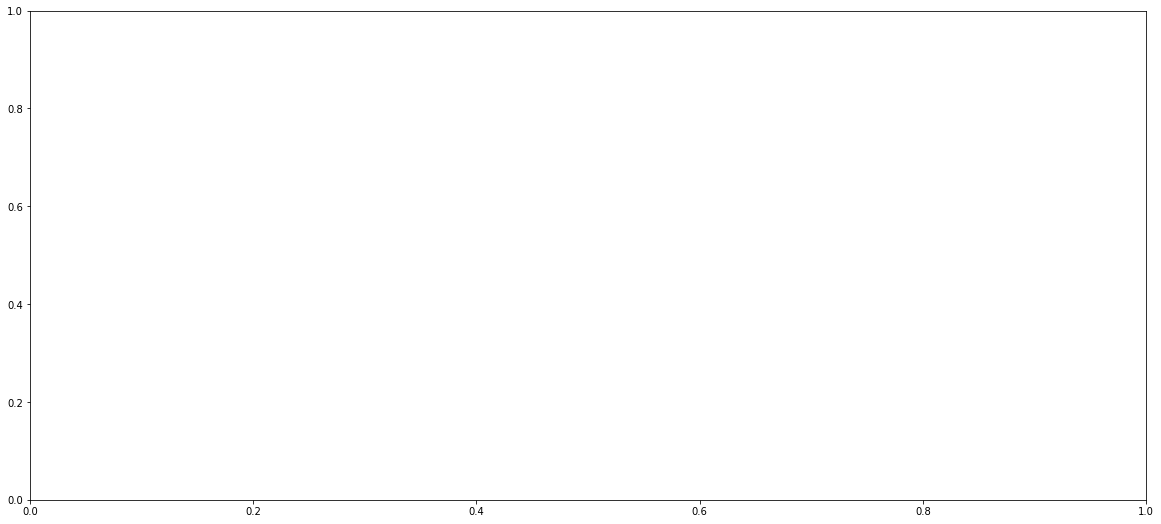

In [19]:
import matplotlib.pyplot as plt
import numpy as np


df_train_new = count_occurences(df=transform_basket_tolist(df_train))

N = 6
books_returned = df_train_new[df_train['returnLabel']==1] 
books_notreturned = df_train_new[df_train['returnLabel']==0]


ind = np.arange(N)    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

array_books_returned = books_returned.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new"]) 
df_calc_books_returned = array_books_returned.sum(axis = 0, skipna = True)
print(array_books_returned)

array_books_noreturned = books_notreturned.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new","customerType"])
df_calc_books_notreturned = array_books_noreturned.sum(axis = 0, skipna = True) # CustomerType wird automatisch geworfen 

plt.figure(figsize=(20,9))

p1 = plt.bar(ind, list(df_calc_books_returned), width)
p2 = plt.bar(ind, list(df_calc_books_notreturned), width,
             bottom=list(df_calc_books_returned))


plt.ylabel('Sum')
plt.title('Book returned vs. not Returned')
plt.xticks(ind, ('Cat_0','Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5'))
plt.yticks(np.arange(0, 40000, 5000))
plt.legend((p1[0], p2[0]), ('Books returned', 'Books no returned'))

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


df_train_new = count_occurences(df=transform_basket_tolist(df_train))

N = 2
returned_by_existing_customer = df_train_new[(df_train_new['returnLabel']==1) & (df_train_new['customerType'] == 'existing')]["customerType"].count()
not_returned_by_existing_customer = df_train_new[(df_train_new['returnLabel']==0) & (df_train_new['customerType'] == 'existing')]["customerType"].count()

returned_by_new_customer = df_train_new[(df_train_new['returnLabel']==1) & (df_train_new['customerType'] == 'new')]["customerType"].count()
not_returned_by_new_customer = df_train_new[(df_train_new['returnLabel']==0) & (df_train_new['customerType'] == 'new')]["customerType"].count()

ind = np.arange(N)    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

returned_list = list((returned_by_existing_customer,returned_by_new_customer))
not_returned_list = list((not_returned_by_existing_customer,not_returned_by_new_customer))

array_books_noreturned = books_notreturned.drop(columns=["totalAmount","returnLabel"])
df_calc_books_notreturned = array_books_noreturned.sum(axis = 0, skipna = True)

plt.figure(figsize=(20,9))

p1 = plt.bar(ind,returned_list , width)
p2 = plt.bar(ind, not_returned_list, width,
             bottom=returned_list)


plt.ylabel('Sum')
plt.title('Book returned vs. not Returned')
plt.xticks(ind, ('existing customer', 'new customer'))
plt.yticks(np.arange(0, 40000, 5000))
plt.legend((p1[0], p2[0]), ('Books returned', 'Books no returned'))

plt.show()

       transactionId  ...                            basket_new
0         7934161612  ...                                   [3]
1         5308629088  ...                          [5, 3, 0, 3]
2         1951363325  ...                          [3, 3, 1, 4]
3         6713597713  ...                                   [2]
4         8352683669  ...                          [4, 4, 4, 4]
...              ...  ...                                   ...
24995     8178087221  ...           [4, 3, 2, 4, 2, 2, 4, 1, 0]
24996     8955146476  ...  [5, 5, 5, 0, 0, 2, 4, 1, 2, 4, 5, 2]
24997     7770630838  ...                    [1, 3, 4, 4, 2, 0]
24998     3758775159  ...                                [5, 3]
24999     7697226342  ...                       [4, 4, 0, 3, 4]

[25000 rows x 6 columns]
       transactionId                                basket  ... Cat_4  Cat_5
0         7934161612                                   [3]  ...     0      0
1         5308629088                          [5, 3,

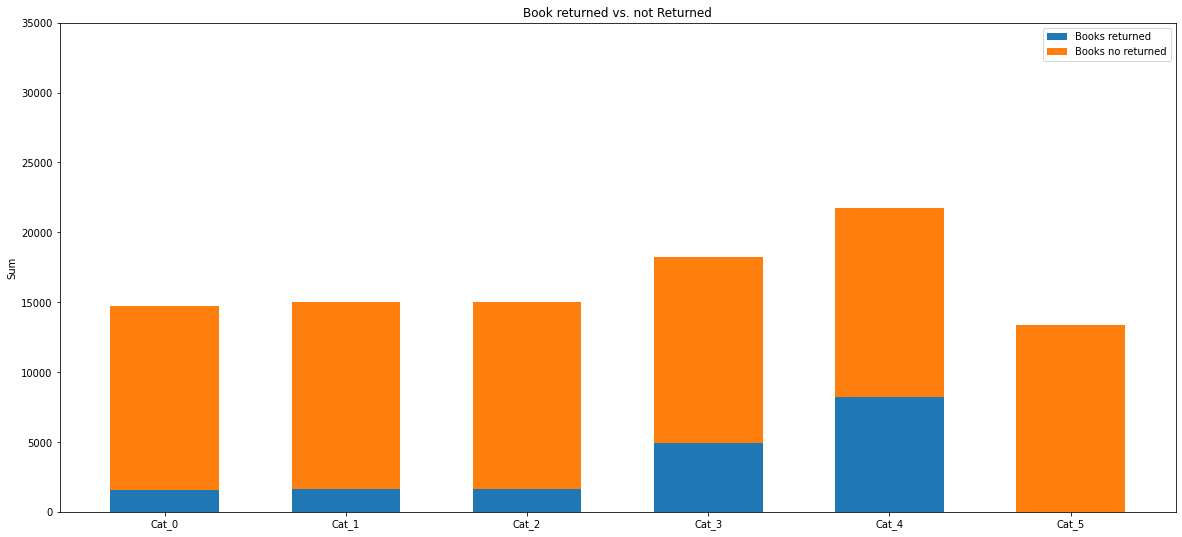

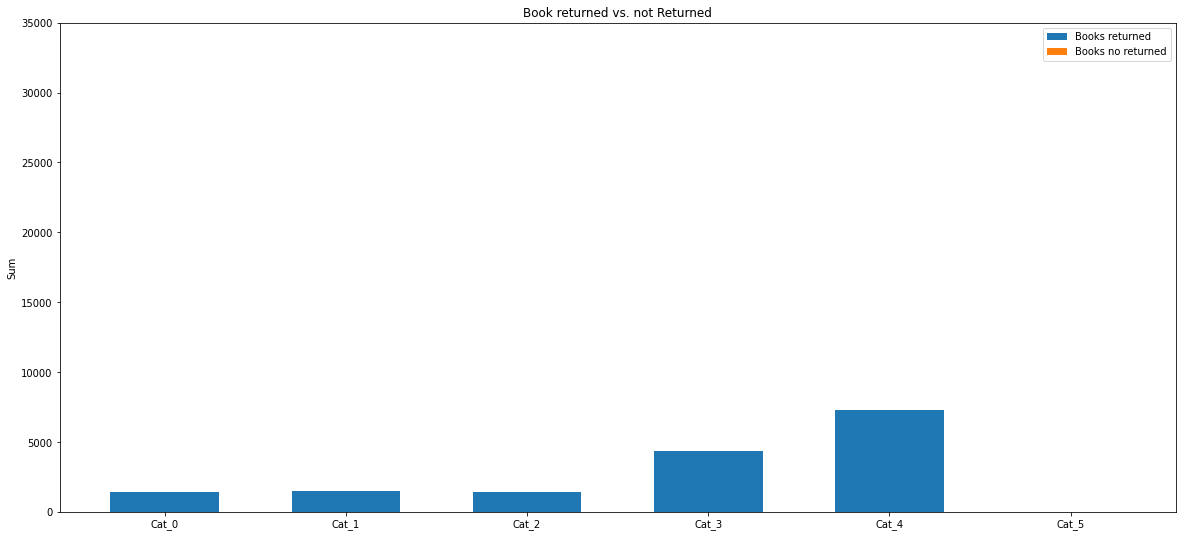

In [ ]:
df_train_new = count_occurences(df=transform_basket_tolist(df_train))

N = 6
books_returned = df_train_new[(df_train_new['returnLabel']==1) & (df_train_new['customerType'] == 'existing')] 
books_notreturned = df_train_new[(df_train_new['returnLabel']==0) & (df_train_new['customerType'] == 'existing')] 


books_returned_new_customer = df_train_new[(df_train_new['returnLabel']==1) & (df_train_new['customerType'] == 'new')] 
books_notreturned_new_customer = df_train_new[(df_train_new['returnLabel']==0) & (df_train_new['customerType'] == 'new')] 



ind = np.arange(N)    # the x locations for the groups
width = 0.6       # the width of the bars: can also be len(x) sequence

array_books_returned = books_returned.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new","customerType"]) 
df_calc_books_returned = array_books_returned.sum(axis = 0, skipna = True)

array_books_noreturned = books_notreturned.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new","customerType"])
df_calc_books_notreturned = array_books_noreturned.sum(axis = 0, skipna = True)

############# New Customer ###########

array_books_returned_new = books_returned_new_customer.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new","customerType"]) 
df_calc_books_returned_new = array_books_returned_new.sum(axis = 0, skipna = True)


array_books_noreturned_new = books_notreturned_new_customer.drop(columns=["totalAmount","returnLabel","transactionId","basket","basket_new","customerType"])
df_calc_books_notreturned_new = array_books_noreturned_new.sum(axis = 0, skipna = True)

############ ###################




plt.figure(figsize=(20,9))

p1 = plt.bar(ind, list(df_calc_books_returned), width)
p2 = plt.bar(ind, list(df_calc_books_notreturned), width,
             bottom=list(df_calc_books_returned))




plt.ylabel('Sum')
plt.title('Book returned vs. not Returned')
plt.xticks(ind, ('Cat_0','Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5'))
plt.yticks(np.arange(0, 40000, 5000))
plt.legend((p1[0], p2[0]), ('Books returned', 'Books no returned'))

plt.show()

plt.figure(figsize=(20,9))

p3 = plt.bar(ind, list(df_calc_books_returned_new), width)
p4 = plt.bar(ind, list(df_calc_books_notreturned_new), width,
             bottom=list(df_calc_books_notreturned_new))


plt.ylabel('Sum')
plt.title('Book returned vs. not Returned')
plt.xticks(ind, ('Cat_0','Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5'))
plt.yticks(np.arange(0, 40000, 5000))
plt.legend((p3[0], p4[0]), ('Books returned', 'Books no returned'))

plt.show()

# Modeling

Logistische Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameter_candidates = [{'C': [0.1,1,4,5,6,10,30,100], 'penalty': ['l1','l2']}]
clf_log = LogisticRegression(random_state=0)
grid_clf_log = GridSearchCV(estimator=clf_log, param_grid=parameter_candidates, n_jobs=-1)
grid_clf_log.fit(X_train, y_train)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 4, 5, 6, 10, 30, 100],
                          'penalty': ['l1', 'l2']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
log_reg_best_est_C= grid_clf_log.best_estimator_.C
log_reg_best_est_pen=grid_clf_log.best_estimator_.penalty
print('Best C:', grid_clf_log.best_estimator_.C) 
print('Best penalty:', grid_clf_log.best_estimator_.penalty)

Best C: 30
Best penalty: l2


In [26]:
#Trainieren des optimalen Modells
clf_log = LogisticRegression(random_state=0, C=log_reg_best_est_C, penalty=log_reg_best_est_pen)
clf_log.fit(X_train, y_train)

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
parameter_candidates = [{'n_estimators': [60,80,100,120,40], 'max_depth': [2,3,4,5]}]
clf_rfc = RandomForestClassifier(random_state=0)
grid_clf_rfc = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, n_jobs=-1)
grid_clf_rfc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                

In [28]:
ran_for_best_est_n=grid_clf_rfc.best_estimator_.n_estimators
ran_for_best_est_depth=grid_clf_rfc.best_estimator_.max_depth
print('Best n_estimators:', grid_clf_rfc.best_estimator_.n_estimators) 
print('Best max_depth:', grid_clf_rfc.best_estimator_.max_depth)

Best n_estimators: 80
Best max_depth: 5


In [29]:
clf_rfc = RandomForestClassifier(random_state=0, max_depth=ran_for_best_est_depth, n_estimators=ran_for_best_est_n)
clf_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Gradient Boosting Tree

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
parameter_candidates = [{'n_estimators': [60,80,100,120,40], 'max_depth': [2,3,4,5]}]
clf_gbc = GradientBoostingClassifier(random_state=0)
grid_clf_gbc = GridSearchCV(estimator=clf_gbc, param_grid=parameter_candidates, n_jobs=-1)
grid_clf_gbc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [31]:
grad_boost_best_est_n=grid_clf_gbc.best_estimator_.n_estimators
grad_boost_best_est_depth=grid_clf_gbc.best_estimator_.max_depth
print('Best n_estimators:', grid_clf_gbc.best_estimator_.n_estimators) 
print('Best max_depth:', grid_clf_gbc.best_estimator_.max_depth)

Best n_estimators: 100
Best max_depth: 5


In [33]:
clf_gbc = GradientBoostingClassifier(random_state=0, max_depth=grad_boost_best_est_depth, n_estimators=grad_boost_best_est_n)
clf_gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Evaluation

Logistische Regression

In [37]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

log_predictions = clf_log.predict(X_test)
log_acc=accuracy_score(y_test, log_predictions)
log_prec=precision_score(y_test, log_predictions)
log_rec=recall_score(y_test, log_predictions)

print("Logistic Regression Accuracy:"+ str(log_acc))
print("Logistic Regression Precision:"+ str(log_prec))
print("Logistic Regression Recall:"+ str(log_rec))

Logistic Regression Accuracy:0.9122562674094707
Logistic Regression Precision:0.9087791495198903
Logistic Regression Recall:0.78125


Random Forest

In [38]:
rfc_predictions = clf_rfc.predict(X_test)
rfc_acc=accuracy_score(y_test, rfc_predictions)
rfc_prec=precision_score(y_test, rfc_predictions)
rfc_rec=recall_score(y_test, rfc_predictions)

print("Logistic Regression Accuracy:"+ str(rfc_acc))
print("Logistic Regression Precision:"+ str(rfc_prec))
print("Logistic Regression Recall:"+ str(rfc_rec))

Logistic Regression Accuracy:0.9089484679665738
Logistic Regression Precision:0.8970886932972241
Logistic Regression Recall:0.78125


Gradient Boosting Classifier

In [39]:
gbc_predictions = clf_gbc.predict(X_test)
gbc_acc=accuracy_score(y_test, gbc_predictions)
gbc_prec=precision_score(y_test, gbc_predictions)
gbc_rec=recall_score(y_test, gbc_predictions)

print("Logistic Regression Accuracy:"+ str(gbc_acc))
print("Logistic Regression Precision:"+ str(gbc_prec))
print("Logistic Regression Recall:"+ str(gbc_rec))

Logistic Regression Accuracy:0.9129526462395543
Logistic Regression Precision:0.8873056994818653
Logistic Regression Recall:0.8077830188679245
